# Camera Calibration

In [15]:
import numpy as np
import glob
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

NX = 9
NY = 6
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((NX*NY, 3), np.float32)
objp[:,:2] = np.mgrid[0:NX, 0:NY].T.reshape(-1, 2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
image_files = glob.glob('camera_cal/*.jpg')

for fname in image_files:
    im = mpimg.imread(fname)
    gray = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (NX, NY), None)
    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

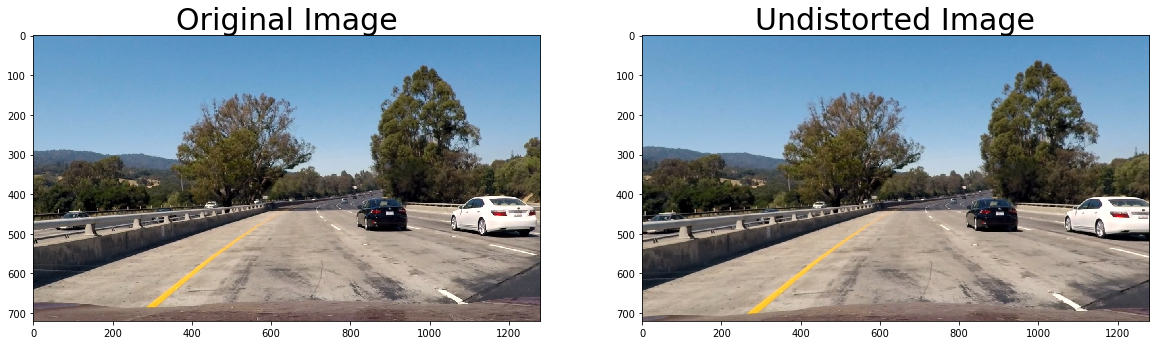

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

test_image = mpimg.imread('test_images/test1.jpg')
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints,
                                                   (test_image.shape[1], test_image.shape[0]), None, None)

def undistort(image):
    return cv2.undistort(image, mtx, dist, None, mtx)

undistorted = undistort(test_image)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(test_image)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=30)

# Gradient & Color Threshold

## Gradient Threshold

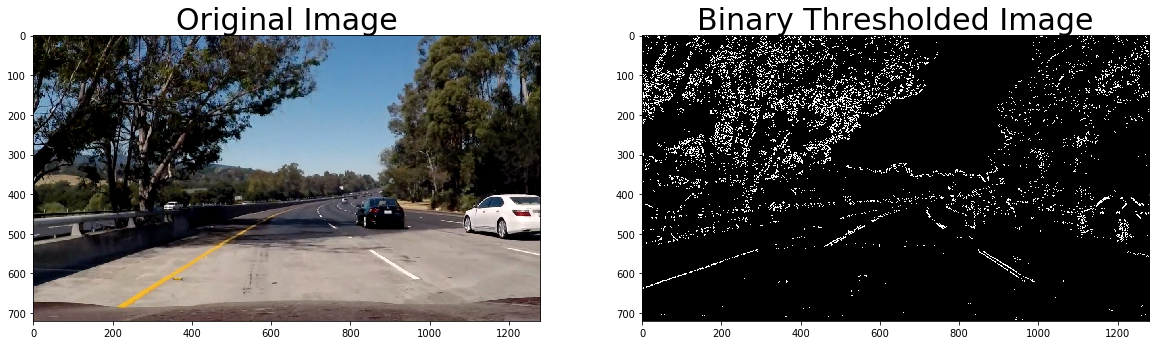

In [17]:
%matplotlib inline

def gradient_threshold(image):
    
    def abs_sobel_thresh(img, orient='x', thresh=(0, 255)):
        # Apply x or y gradient with the OpenCV Sobel() function
        # and take the absolute value
        if orient == 'x':
            abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
        if orient == 'y':
            abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
        # Rescale back to 8 bit integer
        scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
        # Create a copy and apply the threshold
        binary_output = np.zeros_like(scaled_sobel)
        # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
        binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
        # Return the result
        return binary_output
    
    def mag_thresh(img, ksize=3, mag_thresh=(0, 255)):
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=ksize)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=ksize)
        # Calculate the gradient magnitude
        gradmag = np.sqrt(sobelx**2 + sobely**2)
        # Rescale to 8 bit
        scale_factor = np.max(gradmag)/255 
        gradmag = (gradmag/scale_factor).astype(np.uint8) 
        # Create a binary image of ones where threshold is met, zeros otherwise
        binary_output = np.zeros_like(gradmag)
        binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
        # Return the binary image
        return binary_output

    def dir_threshold(img, ksize=3, thresh=(0, np.pi/2)):
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=ksize)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=ksize)
        # Take the absolute value of the gradient direction, 
        # apply a threshold, and create a binary image result
        absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
        binary_output = np.zeros_like(absgraddir)
        binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
        # Return the binary image
        return binary_output
    
    ksize = 3
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    gradx = abs_sobel_thresh(gray, orient='x', thresh=(20, 110))
    grady = abs_sobel_thresh(gray, orient='y', thresh=(20, 110))
    mag_binary = mag_thresh(gray, mag_thresh=(30, 200))
    dir_binary = dir_threshold(gray, thresh=(0.7, 1.3))
    
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    
    return combined
    
test_image = mpimg.imread('test_images/test5.jpg')
binary_output = gradient_threshold(undistort(test_image))

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(test_image)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(binary_output, cmap='gray')
ax2.set_title('Binary Thresholded Image', fontsize=30)

## Color Threshold

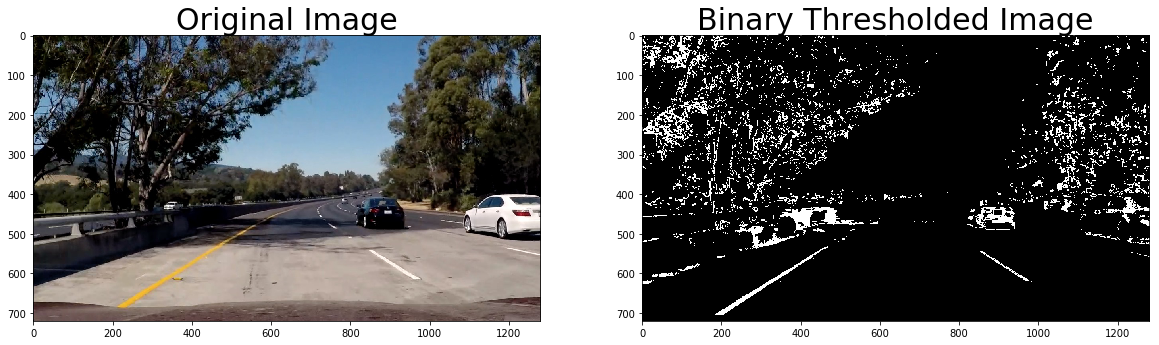

In [18]:
def color_threshold(image):
    thresh = (170, 255)
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS) 
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel >= thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

test_image = mpimg.imread('test_images/test5.jpg')
binary_output = color_threshold(undistort(test_image))

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(test_image)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(binary_output, cmap='gray')
ax2.set_title('Binary Thresholded Image', fontsize=30)

## Combined Threshold

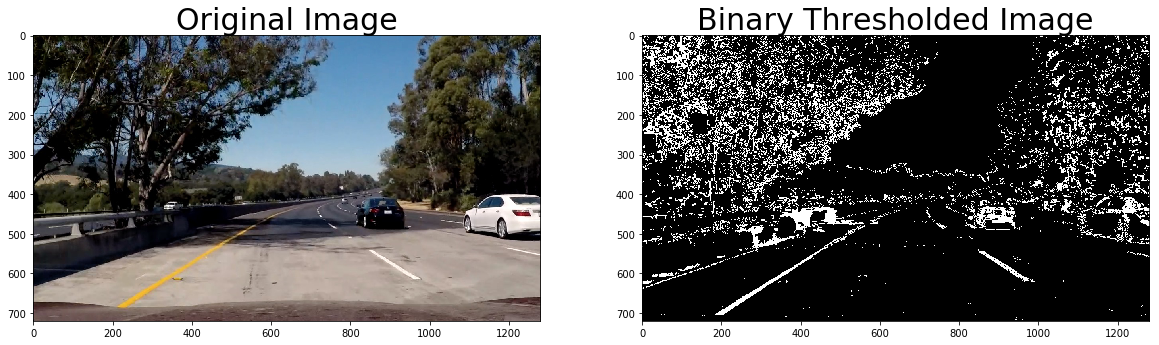

In [19]:
def combined_threshold(image):
    gradient_binary = gradient_threshold(image)
    color_binary = color_threshold(image)
    combined = np.zeros_like(gradient_binary)
    combined[(gradient_binary == 1) | (color_binary == 1)] = 1
    return combined

test_image = mpimg.imread('test_images/test5.jpg')
binary_output = combined_threshold(undistort(test_image))

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(test_image)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(binary_output, cmap='gray')
ax2.set_title('Binary Thresholded Image', fontsize=30)

# Perspective Transform

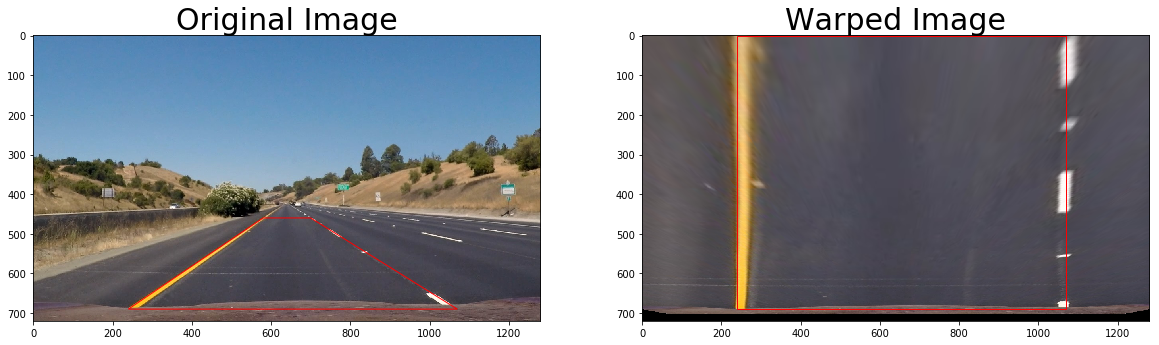

In [50]:
%matplotlib inline
import matplotlib.patches as patches

test_image = mpimg.imread('test_images/straight_lines1.jpg')

# clockwise
src_vertices = np.float32(
    [[700, 460],
     [1070, 690],
     [240, 690],
     [580, 460]])
dst_vertices = np.float32(
    [[1070, 0],
     [1070, 690],
     [240, 690],
     [240, 0]])

M = cv2.getPerspectiveTransform(src_vertices, dst_vertices)
Minv = cv2.getPerspectiveTransform(dst_vertices, src_vertices)

def perspective_transform(image):
    return cv2.warpPerspective(image, M, (image.shape[1], image.shape[0]), flags=cv2.INTER_LINEAR)

def inverse_perspective_transform(image):
    return cv2.warpPerspective(image, Minv, (image.shape[1], image.shape[0]), flags=cv2.INTER_LINEAR)

warped = perspective_transform(test_image)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(test_image)
ax1.add_patch(patches.Polygon(xy=src_vertices, fill=False, edgecolor='r'))
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(warped)
ax2.add_patch(patches.Polygon(xy=dst_vertices, fill=False, edgecolor='r'))
ax2.set_title('Warped Image', fontsize=30)

# Finding Lane Lines

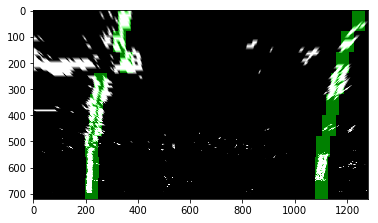

In [56]:
# window settings
window_width = 50 
window_height = 80 # Break image into 9 vertical layers since image height is 720
margin = 100 # How much to slide left and right for searching

def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(image):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(image[int(3*image.shape[0]/4):,:int(image.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(image[int(3*image.shape[0]/4):,int(image.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(image.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center,int(image.shape[0]-0.5*window_height)))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(image.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(image[int(image.shape[0]-(level+1)*window_height):int(image.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,image.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,image.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        # Add what we found for that layer
        window_centroids.append((l_center,r_center,int(image.shape[0]-(level+0.5)*window_height)))

    return window_centroids

test_image = mpimg.imread('test_images/test5.jpg')
binary = combined_threshold(undistort(test_image))
warped = perspective_transform(binary)
window_centroids = find_window_centroids(warped)

# If we found any window centers
if len(window_centroids) > 0:

    # Points used to draw all the left and right windows
    l_points = np.zeros_like(warped)
    r_points = np.zeros_like(warped)

    # Go through each level and draw the windows 	
    for level in range(0,len(window_centroids)):
        # Window_mask is a function to draw window areas
        l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
        r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
        # Add graphic points from window mask here to total pixels found 
        l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
        r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

    # Draw the results
    template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
    zero_channel = np.zeros_like(template) # create a zero color channel
    template = np.array(cv2.merge((zero_channel,template,zero_channel)), np.uint8) # make window pixels green
    warpage= (np.dstack((warped, warped, warped))*255).astype(np.uint8) # making the original road pixels 3 color channels
    output = cv2.addWeighted(warpage, 1.0, template, 0.5, 0.0) # overlay the orignal road image with window results

# If no window centers found, just display orginal road image
else:
    output = np.array(cv2.merge((warped,warped,warped)),np.uint8)

plt.imshow(output)

# Measuring Curvature

Left radius: 1407.3350953660179 Right radius: 1906.4506724455248


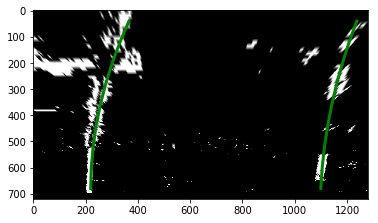

In [59]:
def poly_fit(centroids):
    
    ploty, leftx, rightx = [], [], []
    
    for c in centroids:
        leftx.append(c[0])
        rightx.append(c[1])
        ploty.append(c[2])
    
    leftx = np.array(leftx)
    rightx = np.array(rightx)
    ploty = np.array(ploty)
    
    # Fit a second order polynomial to pixel positions in each fake lane line
    left_fit = np.polyfit(ploty, leftx, 2)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fit = np.polyfit(ploty, rightx, 2)
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])

    return ploty, left_fitx, right_fitx, left_curverad, right_curverad

ploty, left_fitx, right_fitx, left_curverad, right_curverad = poly_fit(window_centroids)

print('Left radius: {}'.format(left_curverad), 'Right radius: {}'.format(right_curverad))

plt.imshow(warped, cmap='gray')
plt.plot(left_fitx, ploty, color='green', linewidth=3)
plt.plot(right_fitx, ploty, color='green', linewidth=3)

# Pipeline

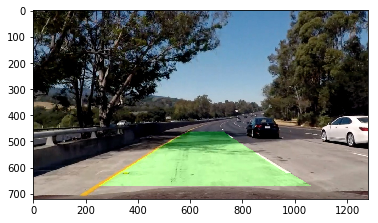

In [62]:
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        # average x values of the fitted line over the last n iterations
        self.bestx = None     
        # polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        # polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        # radius of curvature of the line in some units
        self.radius_of_curvature = None 
        # distance in meters of vehicle center from the line
        self.line_base_pos = None 
        # difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        # x values for detected line pixels
        self.allx = None  
        # y values for detected line pixels
        self.ally = None

def process_image(image):
    undist = undistort(image)
    binary = combined_threshold(undist)
    warped = perspective_transform(binary)
    window_centroids = find_window_centroids(warped)
    ploty, left_fitx, right_fitx, left_curverad, right_curverad = poly_fit(window_centroids)

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = inverse_perspective_transform(color_warp)
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)

    return result

test_image = mpimg.imread('test_images/test5.jpg')
result = process_image(test_image)
plt.imshow(result)

# Project Video

In [70]:
left_lane = Line()
right_lane = Line()

from moviepy.editor import VideoFileClip
from IPython.display import HTML

output_video = 'project_video_annotated.mp4'

video = VideoFileClip("project_video.mp4")
annotated_video = video.fl_image(process_image)
%time annotated_video.write_videofile(output_video, audio=False)

[MoviePy] >>>> Building video project_video_annotated.mp4
[MoviePy] Writing video project_video_annotated.mp4


100%|█████████▉| 1260/1261 [03:05<00:00,  7.15it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_annotated.mp4 

CPU times: user 3min 56s, sys: 3.15 s, total: 3min 59s
Wall time: 3min 6s


In [71]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_video))

# Challenge Video

In [66]:
output_video = 'project_video_annotated.mp4'

video = VideoFileClip("challenge_video.mp4")
annotated_video = video.fl_image(process_image)
%time annotated_video.write_videofile(output_video, audio=False)

[MoviePy] >>>> Building video project_video_annotated.mp4
[MoviePy] Writing video project_video_annotated.mp4


100%|██████████| 485/485 [01:12<00:00,  6.92it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_annotated.mp4 

CPU times: user 1min 31s, sys: 1.51 s, total: 1min 32s
Wall time: 1min 13s


In [67]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_video))

# Harder Challenge Video

In [ ]:
output_video = 'project_video_annotated.mp4'

video = VideoFileClip("harder_challenge_video.mp4")
annotated_video = video.fl_image(process_image)
%time annotated_video.write_videofile(output_video, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_video))